In [ ]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 5.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=78f7c31043d8ee5c691014602c0fa23cca76b9b139b501a10180d88c8e3c31fe
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [ ]:
! pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html
! pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html
! pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html
! pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html
! pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu110.html
  Using cached torch_scatter-2.1.0.tar.gz (106 kB)
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main.py", line 71, in main
    return command.main(cmd_args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 104, in main
    return self._main(args)
  File "/usr/lib/python3.7/contextlib.py", line 119, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/command_context.py", line 22, in main_context
    yield
  File "/usr/lib/python3.7/contextlib.py", line 524, in __exit__
    raise exc_details[1]
  File "/usr/lib/python3.7/contextlib.py", line 130, in __exit__
    self.gen.throw(

In [ ]:
!pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
  Using cached torch_sparse-0.6.15.tar.gz (2.1 MB)
  Using cached torch_scatter-2.1.0.tar.gz (106 kB)
     |████████████████████████████████| 43 kB 1.4 MB/s 
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main.py", line 71, in main
    return command.main(cmd_args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 104, in main
    return self._main(args)
  File "/usr/lib/python3.7/contextlib.py", line 119, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/command_context.py", line 22, in main_context
    yield
  File "/usr/lib/python3.7/contextlib.py", line 524, in __exit__
  

- Compare GCN and GAT


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid

from torchvision import datasets # MNIST datasets
from torchvision.transforms import ToTensor # transform PIL image to torch.Tensor



- Implement GAT

In [84]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0rc1

In [85]:

# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.0.0rc1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.0.0rc1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [86]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
dataset = datasets.CiteSeer()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [89]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4715]
        Weights: all 1 (default)


In [90]:
set(node_subjects)

{'AI', 'Agents', 'DB', 'HCI', 'IR', 'ML'}

In [116]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=700, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=300, test_size=None, stratify=test_subjects
)

In [117]:
from collections import Counter

Counter(train_subjects)

Counter({'DB': 148, 'HCI': 107, 'IR': 141, 'ML': 125, 'Agents': 126, 'AI': 53})

In [118]:

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [119]:
generator = FullBatchNodeGenerator(G, method="gat")

In [120]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [121]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [122]:
x_inp, predictions = gat.in_out_tensors()

In [123]:

model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [124]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [125]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [126]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 3s - loss: 1.8363 - acc: 0.1557 - val_loss: 1.5885 - val_acc: 0.6267 - 3s/epoch - 3s/step
Epoch 2/50
1/1 - 0s - loss: 1.5940 - acc: 0.4700 - val_loss: 1.4131 - val_acc: 0.7367 - 154ms/epoch - 154ms/step
Epoch 3/50
1/1 - 0s - loss: 1.3742 - acc: 0.5943 - val_loss: 1.2695 - val_acc: 0.7500 - 153ms/epoch - 153ms/step
Epoch 4/50
1/1 - 0s - loss: 1.2600 - acc: 0.6329 - val_loss: 1.1533 - val_acc: 0.7333 - 128ms/epoch - 128ms/step
Epoch 5/50
1/1 - 0s - loss: 1.1337 - acc: 0.6614 - val_loss: 1.0601 - val_acc: 0.7367 - 137ms/epoch - 137ms/step
Epoch 6/50
1/1 - 0s - loss: 1.0644 - acc: 0.6800 - val_loss: 0.9877 - val_acc: 0.7467 - 128ms/epoch - 128ms/step
Epoch 7/50
1/1 - 0s - loss: 0.9818 - acc: 0.6871 - val_loss: 0.9327 - val_acc: 0.7533 - 163ms/epoch - 163ms/step
Epoch 8/50
1/1 - 0s - loss: 0.9565 - acc: 0.6957 - val_loss: 0.8936 - val_acc: 0.7500 - 129ms/epoch - 129ms/step
Epoch 9/50
1/1 - 0s - loss: 0.9129 - acc: 0.7157 - val_loss: 0.8658 - val_acc: 0.7533 - 130ms/epoch - 

<class 'dict'>


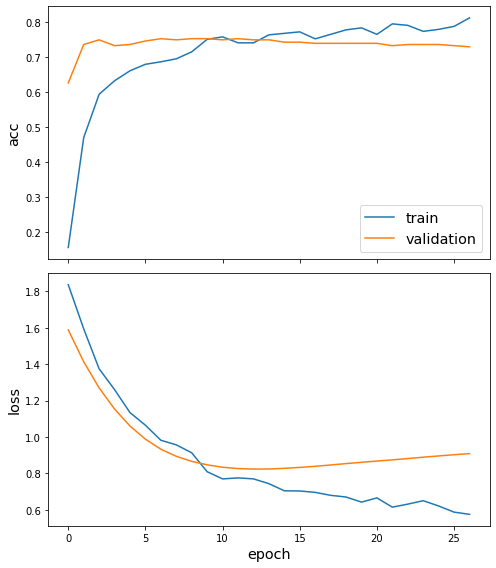

In [127]:
sg.utils.plot_history(history)

In [128]:
model.load_weights("logs/best_model.h5")

In [129]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [130]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 77ms/step - loss: 0.9527 - acc: 0.7379

Test Set Metrics:
	loss: 0.9527
	acc: 0.7379


In [131]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 0s 375ms/step


In [132]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [133]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
100157,Agents,Agents
100598,IR,IR
105684,Agents,Agents
11099,IR,DB
114091,IR,AI
11510,Agents,AI
115971,Agents,Agents
117999,IR,IR
120432,DB,AI
126894,Agents,HCI


In [134]:
emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))
print(
    "Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape)
)

Embedding layer: graph_attention_sparse_10, output shape (1, 3312, 64)


In [135]:
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)

In [136]:
emb = embedding_model.predict(all_gen)
emb.shape

1/1 [==============================] - 0s 315ms/step


(1, 3312, 64)

In [137]:

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [138]:
X = emb.squeeze()
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [139]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


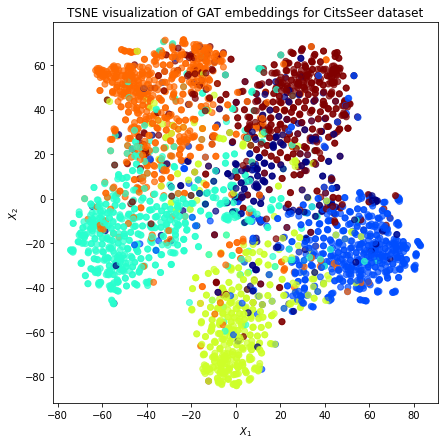

In [141]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GAT embeddings for CitsSeer dataset".format(transform.__name__)
)
plt.show()